# Pokemon

This notebook is an example on how to use the VerticaPy Library. We will use the Pokemon dataset to predict which Pokemon will win on a 1v1 fight. You can download the Jupyter Notebook of the study by clicking <a href="pokemon.ipynb">here</a>. To achieve our goals, we have access to the following data.

A table Pokemon with the information about the different Pokemons (Click <a href="../../data/pokemon/pokemon.csv">here</a> to download the dataset):
<ul class="ul_content">
    <li><b>Legendary:</b> True if it is a Legendary Pokemon</li>
    <li><b>Sp_Atk:</b> Special Attack</li>
    <li><b>Generation:</b> Pokemon Generation</li>
    <li><b>Speed</b></li>
    <li><b>Sp_Def:</b> Special Defense</li>
    <li><b>Name</b></li>
    <li><b>Defense</b></li>
    <li><b>Type_1:</b> Pokemon first Type</li>
    <li><b>Type_2:</b> Pokemon second Type</li>
    <li><b>HP:</b> Number of life points</li>
    <li><b>Attack</b></li>
</ul>

A table combats with information about the different fights (Click <a href="../../data/pokemon/combats.csv">here</a> to download the dataset):
<ul class="ul_content">
    <li><b>First_pokemon:</b> Pokemon of trainer 1</li>
    <li><b>Second_pokemon:</b> Pokemon of trainer 2</li>
    <li><b>Winner:</b> Winner of the fight</li>
</ul>

We will follow the entire Data Science cycle (Data Exploration - Data Preparation - Data Modeling - Model Evaluation - Model Deployment) and solve this easy use-case. The purpose is to show you some of the library interesting functionalities.

## Initialization

Let's ingest the datasets.

In [14]:
from verticapy import *

drop_table('combats')
combats = read_csv('data/combats.csv')
combats.head(5)

The table combats was successfully dropped.
The table "public"."combats" has been successfully created.


<object>  Name: combats, Number of rows: 50000, Number of columns: 3

In [15]:
drop_table('pokemon')
pokemon = read_csv('data/pokemon.csv')
pokemon.head(5)

The table pokemon was successfully dropped.
The table "public"."pokemon" has been successfully created.


<object>  Name: pokemon, Number of rows: 800, Number of columns: 12

## Data Exploration and Preparation

The table 'combats' will be joined to the table 'pokemon' to predict the winner. 

The 'pokemon' table contain all the relevant information about the pokemons. Let's describe this table.

In [3]:
pokemon.describe(method = "categorical")

<object>

The pokemon 'Name', 'Generation' and the variable 'Legendary' will never influence the fight as it is more their combat qualities and types which will help them to get advantages against another pokemon. Let's drop these columns.

In [4]:
pokemon.drop(["Generation", 
              "Legendary", 
              "Name"])

<object>  Name: pokemon, Number of rows: 800, Number of columns: 9

The 'ID' will be the key to join the data. By joining the data, we will be able to create more relevant features.

In [5]:
fights = pokemon.join(combats, 
                      on = {"ID": "First_Pokemon"}, 
                      how = "inner",
                      expr1 = ["Sp_Atk AS Sp_Atk_1", 
                               "Speed AS Speed_1", 
                               "Sp_Def AS Sp_Def_1", 
                               "Defense AS Defense_1", 
                               "Type_1 AS Type_1_1", 
                               "Type_2 AS Type_2_1", 
                               "HP AS HP_1", 
                               "Attack AS Attack_1"],
                      expr2 = ["First_Pokemon", 
                               "Second_Pokemon", 
                               "Winner"]).join(pokemon, 
                      on = {"Second_Pokemon": "ID"}, 
                      how = "inner",
                      expr2 = ["Sp_Atk AS Sp_Atk_2", 
                               "Speed AS Speed_2", 
                               "Sp_Def AS Sp_Def_2", 
                               "Defense AS Defense_2", 
                               "Type_1 AS Type_1_2", 
                               "Type_2 AS Type_2_2", 
                               "HP AS HP_2", 
                               "Attack AS Attack_2"],
                      expr1 = ["Sp_Atk_1", 
                               "Speed_1", 
                               "Sp_Def_1", 
                               "Defense_1", 
                               "Type_1_1", 
                               "Type_2_1", 
                               "HP_1", 
                               "Attack_1", 
                               "Winner", 
                               "Second_pokemon"])

Features Engineering is the key and by computing the difference between pokemon 1 and 2 qualities, we can create amazing features. We can also change Winner to a binary signal (1 if the first pokemon won, 0 otherwise).

In [6]:
fights.eval("Sp_Atk_diff", "Sp_Atk_1 - Sp_Atk_2")
fights.eval("Speed_diff", "Speed_1 - Speed_2")
fights.eval("Sp_Def_diff", "Sp_Def_1 - Sp_Def_2")
fights.eval("Defense_diff", "Defense_1 - Defense_2")
fights.eval("HP_diff", "HP_1 - HP_2")
fights.eval("Attack_diff", "Attack_1 - Attack_2")
fights["Winner"].apply("(CASE WHEN {} = Second_pokemon THEN 0 ELSE 1 END)")
fights = fights.select(["Sp_Atk_diff", "Speed_diff", "Sp_Def_diff", 
                        "Defense_diff", "HP_diff", "Attack_diff", 
                        "Type_1_1", "Type_1_2", "Type_2_1", "Type_2_2", 
                        "Winner"])
print(fights)

<object>  Name: join, Number of rows: 50000, Number of columns: 11


Missing values can not be handled by most of the ML models. Let's see which feature must be imputed.

In [7]:
fights.count()

<object>

Only the pokemon 'second type' (Type_2_1 and Type_2_2) feature has many missing values. These ones are MNAR (A Pokemon may possibly not have a second type), we can impute the missing values by creating another category.

In [8]:
fights["Type_2_1"].fillna("No")
fights["Type_2_2"].fillna("No")

24031 element(s) was/were filled
23985 element(s) was/were filled


<object>  Name: join, Number of rows: 50000, Number of columns: 11

Let's now look at the current relation to see the SQL code generation.

In [9]:
print(fights.current_relation())

(
   SELECT
     "Sp_Atk_diff",
     "Speed_diff",
     "Sp_Def_diff",
     "Defense_diff",
     "HP_diff",
     "Attack_diff",
     "Type_1_1",
     "Type_1_2",
     COALESCE("Type_2_1", 'No') AS "Type_2_1",
     COALESCE("Type_2_2", 'No') AS "Type_2_2",
     "Winner" 
   FROM
 (
   SELECT
     "Sp_Atk_diff",
     "Speed_diff",
     "Sp_Def_diff",
     "Defense_diff",
     "HP_diff",
     "Attack_diff",
     "Type_1_1",
     "Type_1_2",
     "Type_2_1",
     "Type_2_2",
     "Winner" 
   FROM
 (
   SELECT
     "Sp_Atk_diff",
     "Speed_diff",
     "Sp_Def_diff",
     "Defense_diff",
     "HP_diff",
     "Attack_diff",
     "Type_1_1",
     "Type_1_2",
     "Type_2_1",
     "Type_2_2",
     "Winner" 
   FROM
 (
   SELECT
     "Sp_Atk_1",
     "Speed_1",
     "Sp_Def_1",
     "Defense_1",
     "Type_1_1",
     "Type_2_1",
     "HP_1",
     "Attack_1",
     (CASE WHEN "Winner" = Second_pokemon THEN 0 ELSE 1 END) AS "Winner",
     "Second_pokemon",
     "Sp_Atk_2",
     "Speed_2",
     "

VerticaPy will keep in mind your modifications to generate the correct SQL query.

Let's look at the correlations between all the variables.

In [10]:
%matplotlib inline
fights.corr(method = "spearman")

<object>

Many variables are correlated to the response column. We have enough information to create our predictive model. Let's save the view in the DB and create our ML model.

In [11]:
drop_table("pokemons_fights")
x = fights.to_db("pokemons_fights", relation_type = "table")

The table pokemons_fights was successfully dropped.


## Machine Learning

Some really important features are categorical. Random Forest can handle them. Besides, we need trees which are deep enough to compare all the different types.

In [12]:
from verticapy.learn.ensemble import RandomForestClassifier
from verticapy.learn.model_selection import cross_validate

predictors = fights.get_columns(exclude_columns = ['Winner'])
response = "Winner"
relation = "pokemons_fights"
model = RandomForestClassifier("rf_pokemon", 
                               n_estimators = 50, 
                               max_depth = 100, 
                               max_leaf_nodes = 400, 
                               nbins = 100)
model.drop()
cross_validate(model, relation, predictors, response)

<object>

The model is excellent with an averaged AUC of more than 99%. Let's create a model with the entire dataset and look at the features importance.

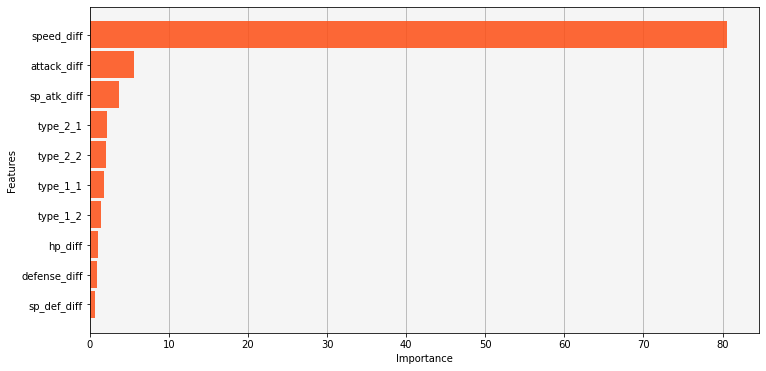

In [13]:
x = model.fit(relation, 
              predictors, 
              response).features_importance()

Fast Pokemons with high Attack will be more able to win their fights!

## Conclusion

We have solved this use-case in a pandas-like way but we never loaded the data in memory. This example showed an overview of the library. You can now start your own project by looking at the documentation first.